In [7]:
from autoscalingsim import simulator
import pandas as pd

starting_time = pd.Timestamp("2020-09-17T10:00:00")
simulation_step = pd.Timedelta(10, unit = 'ms')
time_to_simulate_days = 0.001#0.005
config_dir = "experiments/test"
results_dir = None

simulator = simulator.Simulator(simulation_step,
                                starting_time,
                                time_to_simulate_days)

simulator.add_simulation(config_dir,
                         results_dir)

simulator.start_simulation()

 17%|████████████▉                                                               | 1469/8640 [00:00<00:04, 1480.07it/s]

[2020-11-13 19:15:46.109332] Left to simulate: 0 days 00:01:16.400000 min or 7640 steps


 26%|███████████████████▉                                                        | 2270/8640 [00:01<00:03, 1831.94it/s]

[2020-11-13 19:15:46.621965] Left to simulate: 0 days 00:01:06.400000 min or 6640 steps


 36%|███████████████████████████▏                                                | 3084/8640 [00:01<00:03, 1455.68it/s]

[2020-11-13 19:15:47.114678] Left to simulate: 0 days 00:00:56.400000 min or 5640 steps


 50%|█████████████████████████████████████▋                                      | 4291/8640 [00:02<00:02, 1936.88it/s]

[2020-11-13 19:15:47.736089] Left to simulate: 0 days 00:00:46.400000 min or 4640 steps


 61%|██████████████████████████████████████████████▋                             | 5305/8640 [00:02<00:01, 1987.13it/s]

[2020-11-13 19:15:48.232737] Left to simulate: 0 days 00:00:36.400000 min or 3640 steps


 75%|█████████████████████████████████████████████████████████▎                  | 6520/8640 [00:03<00:01, 1731.80it/s]

[2020-11-13 19:15:48.732427] Left to simulate: 0 days 00:00:26.400000 min or 2640 steps


 85%|████████████████████████████████████████████████████████████████▎           | 7317/8640 [00:03<00:00, 1882.97it/s]

[2020-11-13 19:15:49.340501] Left to simulate: 0 days 00:00:16.400000 min or 1640 steps


 98%|██████████████████████████████████████████████████████████████████████████▊ | 8508/8640 [00:04<00:00, 1953.46it/s]

[2020-11-13 19:15:49.862081] Left to simulate: 0 days 00:00:06.400000 min or 640 steps


8641it [00:04, 1861.55it/s]                                                                                            


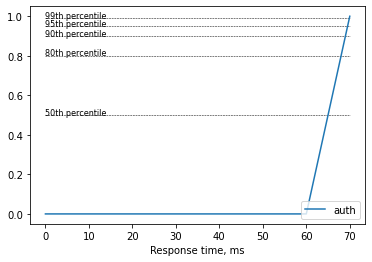

<Figure size 432x288 with 0 Axes>

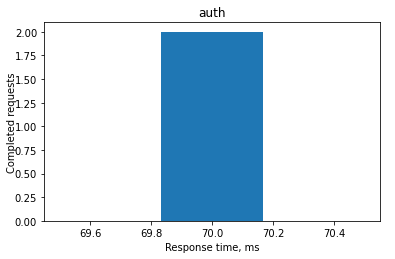

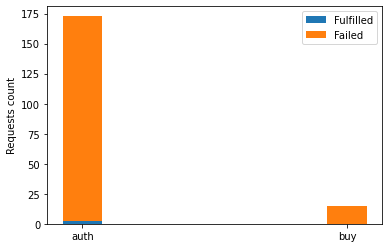

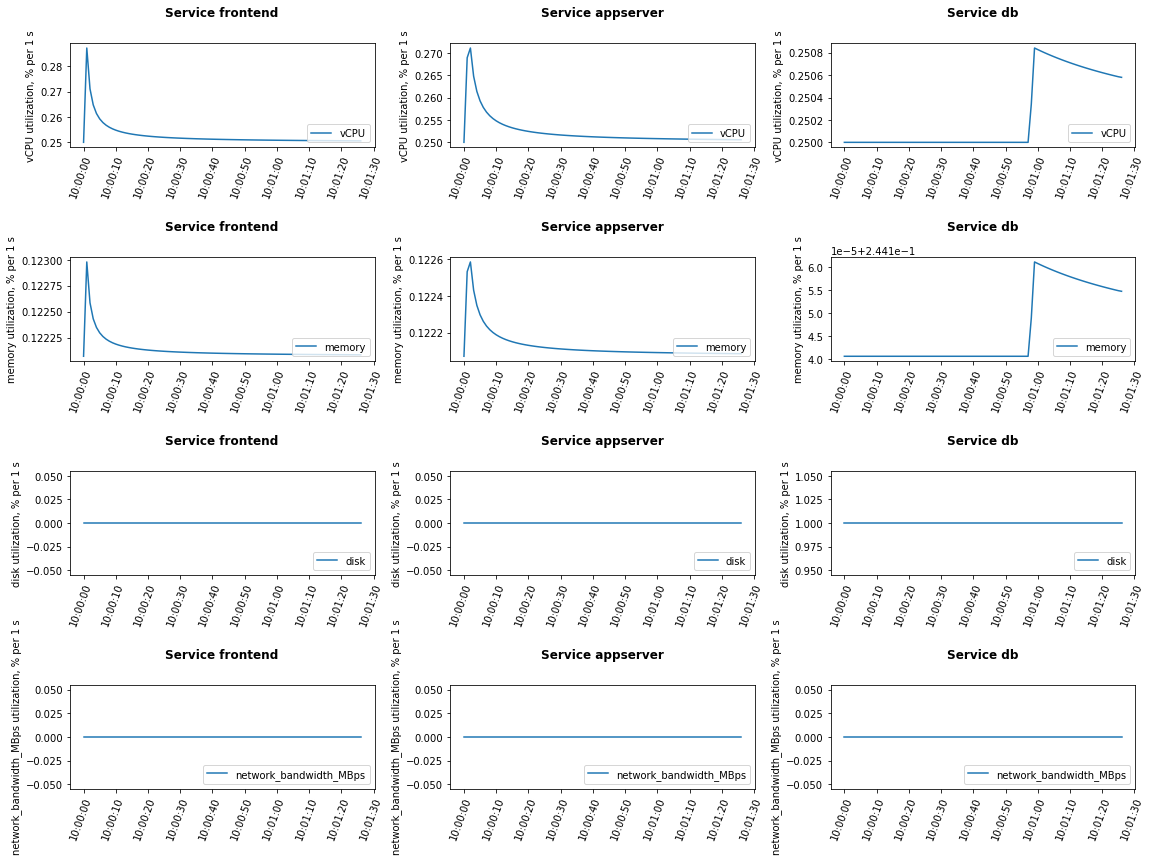

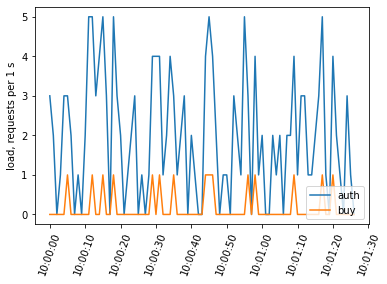

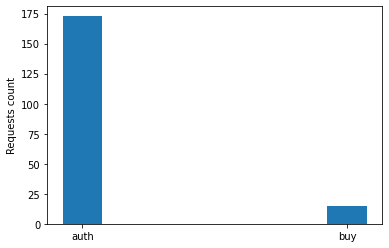

<Figure size 432x288 with 0 Axes>

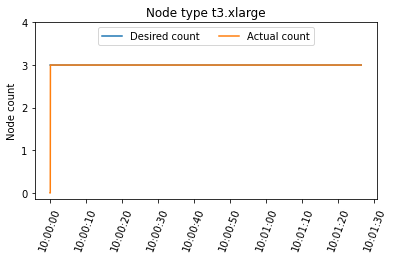

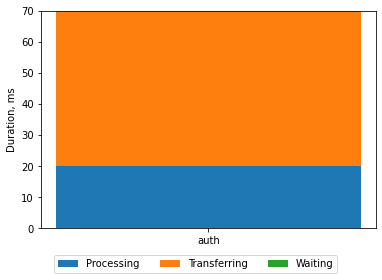

In [8]:
from autoscalingsim.analysis.analytical_engine import AnalysisFramework

af = AnalysisFramework(simulation_step, 'D:/AutoscalingSim/results/test')
af.build_figures(simulator.simulations['test'], '')

  2%|█▌                                                                                | 8/432 [00:00<00:07, 59.85it/s]

Evaluation run 1 out of 2, please wait for all the simulations to finish...


433it [00:23, 18.33it/s]                                                                                               
433it [00:21, 19.98it/s]                                                                                               
  2%|█▎                                                                                | 7/432 [00:00<00:06, 61.03it/s]

Evaluation run 2 out of 2, please wait for all the simulations to finish...


433it [00:22, 19.64it/s]                                                                                               
433it [00:19, 21.71it/s]                                                                                               


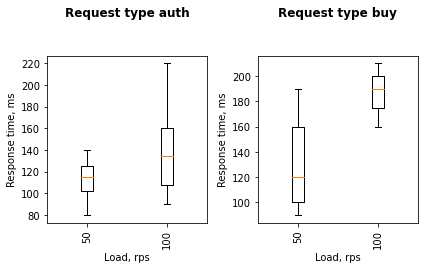

In [5]:
from autoscalingsim.simevaluator.evaluation_framework import SimulationQualityEvaluationFramework

sqef = SimulationQualityEvaluationFramework('experiments/testevaluation/evaluator_conf.json')
sqef.create_simulations()
sqef.simulate()
sqef.build_figures('D:/AutoscalingSim/results/test')